In [1]:
from typing import Union, List
import pickle
import os

import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import functional as F
from IPython.display import clear_output
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from tqdm import tqdm

from nn.module import Linear, SoftmaxActivation, ReLUActivation, SigmoidActivation
from nn.value import Value
from nn.tensor import Tensor
from nn.optimizer import VanillaGradientDescentOptimizer, MomentumOptimizer, AdamOptimizer, RMSPropOptimizer


## Data preparation

In [2]:
class Mnist(Dataset):

    def __init__(self, train=True):
        try:
            self.data = datasets.MNIST(root='./', train=train, download=False, transform=ToTensor())
        except RuntimeError:
            self.data = datasets.MNIST(root='./', train=train, download=True , transform=ToTensor())
            clear_output()

        self.x = self.data.data / 255.
        self.labels = self.data.targets
        self.y = F.one_hot(self.labels, num_classes=10).float()

    def __len__(self): 
        return self.x.shape[0]

    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [3]:
train = Mnist(train=True)

train.x.shape, train.labels.shape, train.y.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]), torch.Size([60000, 10]))

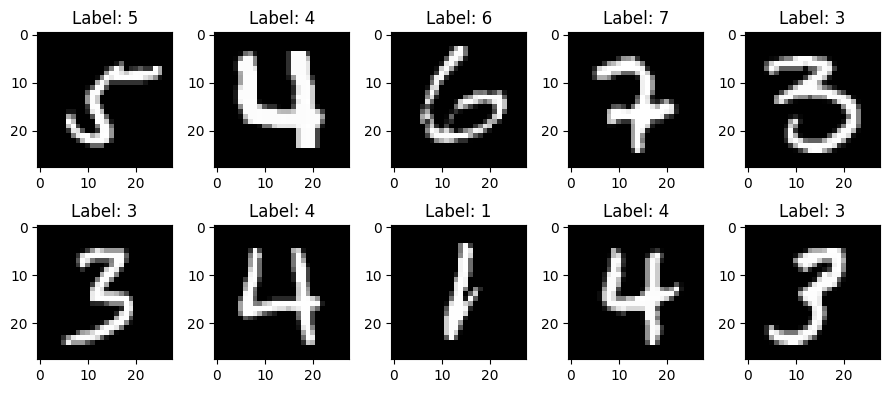

In [4]:
generator = torch.manual_seed(1003)
fig, axes = plt.subplots(2, 5, figsize=(9, 4))
for i, sample in enumerate(torch.randint(len(train), (10, ), generator=generator)):
    ax = axes[i // 5, i % 5]
    ax.imshow(train.x[sample], cmap='gray')
    ax.set_title('Label: {}'.format(train.labels[sample]))
_ = plt.tight_layout()

In [5]:
batch_size = 32 * 2

train_dataloader = DataLoader(train, batch_size=batch_size)

## NN models

### Single layer NN

In [6]:
class SingleLayerNN:
    def __init__(self, num_inputs, num_outputs, activation_class=SoftmaxActivation):
        self._num_inputs = num_inputs
        self._num_outputs = num_outputs
        self._linear_layer = Linear(num_inputs, num_outputs)
        self._activation_layer = activation_class(num_outputs)

    def __call__(self, X: Union[List[List[float]], torch.Tensor]) -> List[List[float]]:
        """Forward pass for multiple samples

        Parameters
        ----------
        X: 2D array (list or torch.Tensor)
            Input samples (each row is a sample)

        Return
        ------
            2D list of floats
        """
        logits = self._linear_layer(X)
        return self._activation_layer(logits)

    def _single_sample_forward(self, x):
        logits = self._linear_layer(x)
        return self._activation_layer(logits)

    def parameters(self):
        return self._linear_layer.parameters() + self._activation_layer.parameters()

single_layer_nn = SingleLayerNN(28 ** 2, 10)

### MLP

In [7]:
class MLP:
    def __init__(self):
        self._layers = [Linear(28**2, 16), Linear(16, 16), Linear(16, 10)]
        self._activations = [SigmoidActivation(16), ReLUActivation(16), SoftmaxActivation(10)]

    def __call__(self, X: Tensor) -> Tensor:
        """Forward pass for multiple samples

        Parameters
        ----------
        X: 2D Tensor
            Input samples (each row is a sample)

        Return
        ------
            2D Tensor
        """
        for linear_layer, activation_layer in zip(self._layers, self._activations):
            X = linear_layer(X)
            X = activation_layer(X)

        return X

    def parameters(self) -> List[Tensor]:
        params = []
        for layer in self._layers:
            params.extend(layer.parameters())
        for activation in self._activations:
            params.extend(activation.parameters())

        return params

mlp = MLP()

## Losses

In [8]:
def mse_loss(Y_pred: List[List[Tensor]], Y: torch.Tensor):
    """
    Parameters
    ----------
    Y_pred: 2D array
        each row is corresponds to a sample
    Y: 2D array
        each row is corresponds to a sample
    """
    if isinstance(Y, torch.Tensor):
        Y = Y.tolist()
    n = len(Y_pred)
    loss = 0
    for y_pred, y in zip(Y_pred, Y):
        loss = loss + sum((y_pred_i - y_i)**2 for y_pred_i, y_i in zip(y_pred, y))
    loss = loss / n
    return loss

def cross_entropy_loss(Y_pred: Tensor, Y: torch.Tensor):
    if isinstance(Y, torch.Tensor):
        Y = Y.numpy().astype(np.float64)
    n = len(Y)
    loss = (Y_pred * Y).sum(1).log().sum() / n
    return -loss

## Training

In [9]:
def train_one_epoch(model, dataloader, L, optimizer):
    train_loss = 0.

    with tqdm(enumerate(dataloader), unit="batch") as tepoch:
        for idx, (X, y) in tepoch:
            X = Tensor(X.reshape(X.shape[0], -1).numpy().astype(np.float64))

            pred = model(X)
            loss = L(pred, y)

            train_loss += loss.data

            optimizer.zero_grad()
            loss.back_prop()
            optimizer.step()

            tepoch.set_postfix(batch_loss=np.round(loss.data, 2), total_loss_so_far=train_loss / (idx + 1))

    return train_loss / (idx + 1)

### Training Single Layer Neural Net

In [10]:
for lr in [0.01, 0.001]:
    adam_optimizer = AdamOptimizer(single_layer_nn.parameters(), lr=lr)
    _ = train_one_epoch(single_layer_nn, train_dataloader, cross_entropy_loss, adam_optimizer)

0batch [00:00, ?batch/s]/home/bohdan/MFML/NN/nn/optimizer.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gradient = np.array([param.grad for param in self._parameters])
/home/bohdan/MFML/NN/nn/optimizer.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  delta_parameters = - self._lr * corrected_moment / (np.array([np.sqrt(arr) for arr in corrected_second_moment]) + self._eps)
938batch [07:13,  2.16batch/s, batch_loss=0.11, total_loss_so_far=1.2] 
938batch [07:13,  2.16batch/s, batch_loss=0.06, total_loss_so_far=0.487]


In [60]:
def load_single_layer_nn():
    dirname = 'single_layer_nn'
    with open(os.path.join(dirname, "weights_tensor"), 'rb') as f:
        slnn_weights = pickle.load(f)
    with open(os.path.join(dirname, "biases_tensor"), 'rb') as f:
        slnn_biases = pickle.load(f)

    slnn = SingleLayerNN(28**2, 10)
    slnn._linear_layer._weights.data = slnn_weights
    slnn._linear_layer._biases.data = slnn_biases

    return slnn

# # Uncomment and run to save load the saved model
# single_layer_nn = load_single_layer_nn()

In [38]:
def save_single_layer_nn(slnn):
    dirname = 'single_layer_nn'
    os.makedirs(dirname, exist_ok=True)
    with open(os.path.join(dirname, "weights_tensor"), 'wb') as f:
        pickle.dump(single_layer_nn._linear_layer._weights.data, f)
    with open(os.path.join(dirname, "biases_tensor"), 'wb') as f:
        pickle.dump(single_layer_nn._linear_layer._biases.data, f)
# # Uncomment and run to save the parameters
# save_single_layer_nn(single_layer_nn)

After training, let's evaluate the results:

In [68]:
def train_metrics(model):
    train_numpy = train.x.numpy().astype(np.float64)
    train_numpy = train_numpy.reshape(train_numpy.shape[0], -1)
    pred_y = model(Tensor(train_numpy)).data
    pred_labels = np.argmax(pred_y, 1)

    loss = -np.log(np.sum(pred_y * train.y.numpy(), axis=1)).mean()
    acc = np.mean((pred_labels == train.labels.numpy()).astype(np.float64))

    print(f"Train Loss: {loss:.2f}")
    print(f"Train Accuracy: {acc:.2f}")

train_metrics(single_layer_nn)

Train Loss: 0.42
Train Accuracy: 0.91


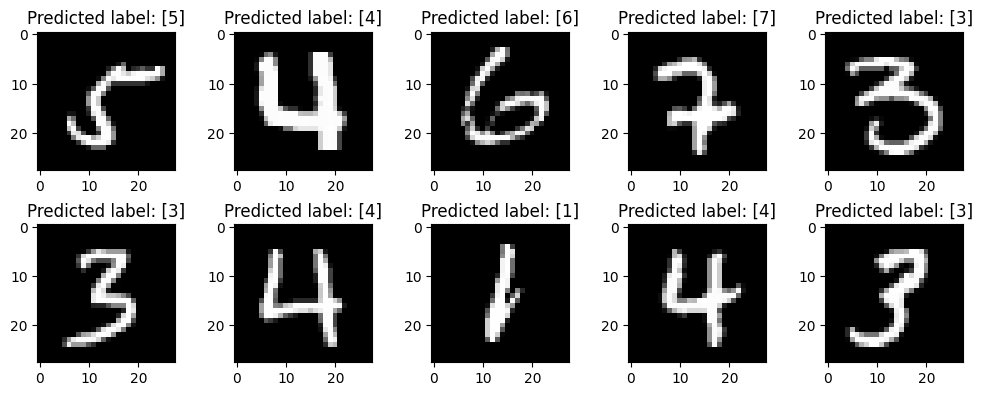

In [65]:
generator = torch.manual_seed(1003)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, sample in enumerate(torch.randint(len(train), (10, ), generator=generator)):
    ax = axes[i // 5, i % 5]
    ax.imshow(train.x[sample], cmap='gray')
    predicted_label = single_layer_nn(Tensor(train.x[sample].numpy().reshape(1, -1).astype(np.float64))).data
    predicted_label = np.argmax(predicted_label, 1)
    ax.set_title('Predicted label: {}'.format(predicted_label))
_ = plt.tight_layout()

### Training MLP

In [89]:
for lr_rate in [0.01, 0.001]:
    adam_optimizer = AdamOptimizer(mlp.parameters(), lr=lr_rate)
    _ = train_one_epoch(mlp, train_dataloader, cross_entropy_loss, adam_optimizer)

0batch [00:00, ?batch/s]/home/bohdan/MFML/NN/nn/optimizer.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gradient = np.array([param.grad for param in self._parameters])
/home/bohdan/MFML/NN/nn/optimizer.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  delta_parameters = - self._lr * corrected_moment / (np.array([np.sqrt(arr) for arr in corrected_second_moment]) + self._eps)
938batch [12:15,  1.28batch/s, batch_loss=0.18, total_loss_so_far=0.661]


0.661474116553944

In [92]:
def save_mlp(mlp: MLP):
    dirname = 'mlp'
    os.makedirs(dirname, exist_ok=True)
    for layer_idx, linear_layer in enumerate(mlp._layers):
        with open(os.path.join(dirname, f"{layer_idx}_weights_tensor"), 'wb') as f:
            pickle.dump(linear_layer._weights.data, f)
        with open(os.path.join(dirname, f"{layer_idx}_biases_tensor"), 'wb') as f:
            pickle.dump(linear_layer._biases.data, f)
# # Uncomment and run to save the parameters
# save_mlp(mlp)

In [93]:
train_metrics(mlp)

Train Loss: 0.36
Train Accuracy: 0.90
